In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
# Load the dataset
file_path = 'filtered_weather_data.csv'
weather_data = pd.read_csv(file_path)

# Convert 'dt_iso' to datetime format to allow grouping by day
weather_data['dt_iso'] = pd.to_datetime(weather_data['dt_iso'], format='%m/%d/%Y %H:%M')

# Aggregate daily rainfall data
weather_data['date'] = weather_data['dt_iso'].dt.date
daily_rainfall = weather_data.groupby('date')['rain_1h'].sum().reset_index()
daily_rainfall['date'] = pd.to_datetime(daily_rainfall['date'])

In [5]:
# Normalize the rainfall data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
lstm_data = scaler.fit_transform(daily_rainfall['rain_1h'].values.reshape(-1, 1))

# Split data into 60% training, 20% validation, and 20% testing
train_size = int(len(lstm_data) * 0.6)
val_size = int(len(lstm_data) * 0.2)
test_size = len(lstm_data) - train_size - val_size

train_data = lstm_data[:train_size]
val_data = lstm_data[train_size:train_size + val_size]
test_data = lstm_data[train_size + val_size:]

In [7]:
# Define function to create dataset for LSTM
def create_dataset(data, time_step=30):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)


In [9]:
# Create LSTM datasets
time_step = 30
X_train, Y_train = create_dataset(train_data, time_step)
X_val, Y_val = create_dataset(val_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

A:\Anacoda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 4/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 5/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 6/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 7/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 10/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 11/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 12/20
164/164 ━━━━━━━━━━━━━━━━━━━━

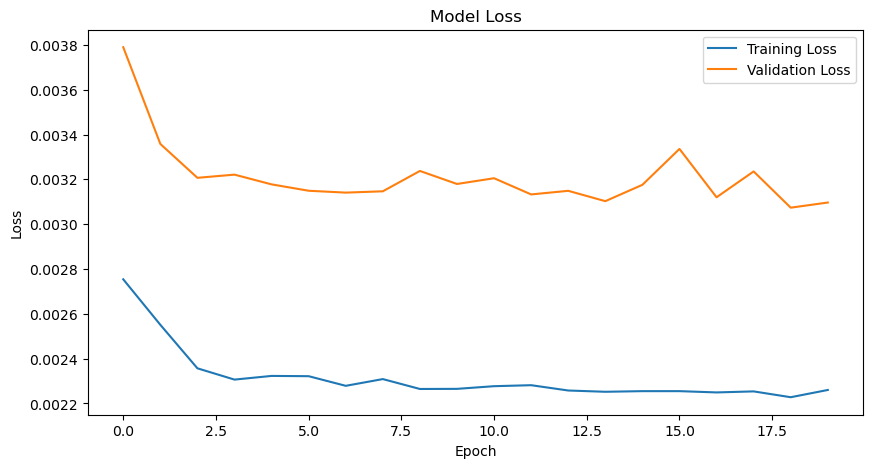

In [13]:
# Compile the LSTM model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model with validation data
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val), verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [15]:
# Calculate error metrics for LSTM
mae_lstm = mean_absolute_error(Y_test, test_predict)
mse_lstm = mean_squared_error(Y_test, test_predict)
rmse_lstm = np.sqrt(mse_lstm)

print("LSTM Model - Mean Absolute Error (MAE):", mae_lstm)
print("LSTM Model - Mean Squared Error (MSE):", mse_lstm)
print("LSTM Model - Root Mean Squared Error (RMSE):", rmse_lstm)

LSTM Model - Mean Absolute Error (MAE): 9.078419654744822
LSTM Model - Mean Squared Error (MSE): 352.65073826948117
LSTM Model - Root Mean Squared Error (RMSE): 18.77899726474982


Predicted flood days and forecasted rainfall:
           date  forecasted_rain
8323 2022-10-15        121.56778


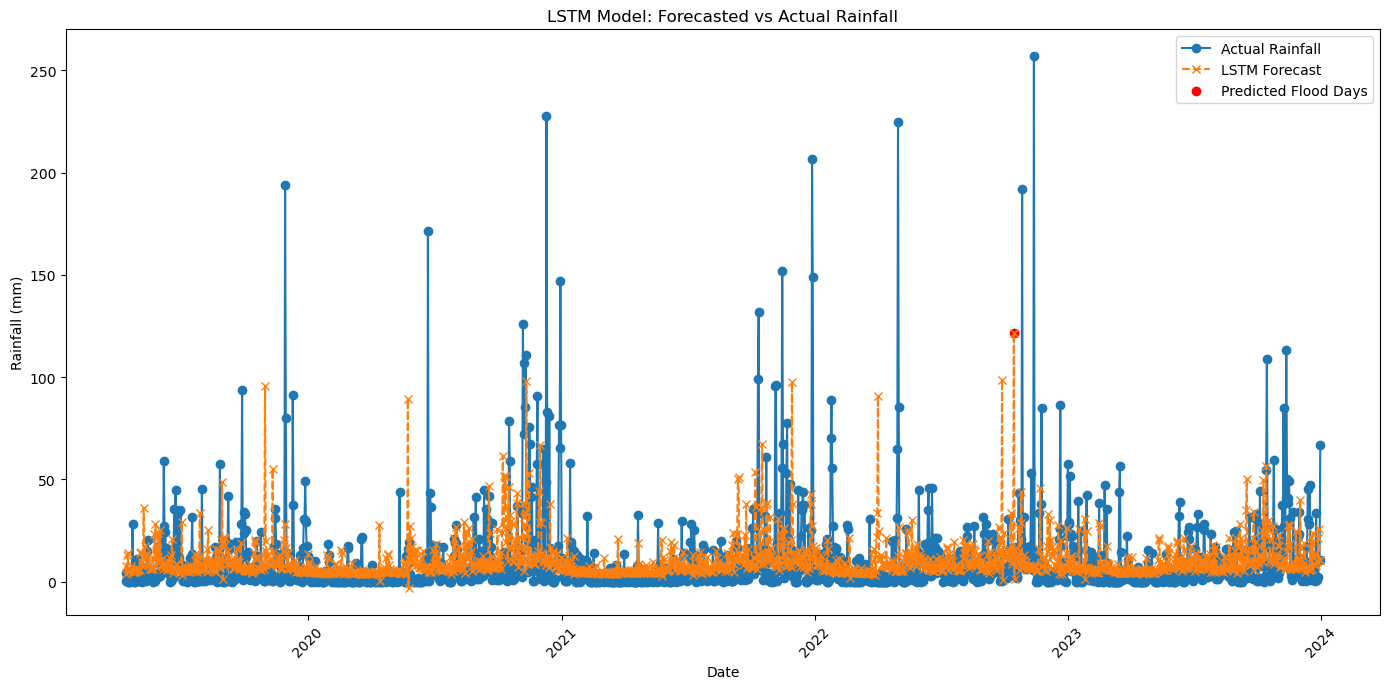

In [19]:
# Step 6: Forecast flood days based on a threshold
flood_threshold = 100  # Define threshold for flood-prone days
flood_days_lstm = daily_rainfall.iloc[-len(test_predict):].copy()
flood_days_lstm['forecasted_rain'] = test_predict
flood_days_lstm['predicted_flood'] = flood_days_lstm['forecasted_rain'].apply(lambda x: 1 if x >= flood_threshold else 0)

# Display the dates predicted to have floods
predicted_flood_days = flood_days_lstm[flood_days_lstm['predicted_flood'] == 1][['date', 'forecasted_rain']]
print("Predicted flood days and forecasted rainfall:")
print(predicted_flood_days)

# Step 7: Visualize the actual vs predicted rainfall
plt.figure(figsize=(14, 7))
plt.plot(flood_days_lstm['date'], scaler.inverse_transform(test_data[:len(flood_days_lstm)]).flatten(), label='Actual Rainfall', marker='o')
plt.plot(flood_days_lstm['date'], test_predict.flatten(), label='LSTM Forecast', linestyle='--', marker='x')
plt.scatter(predicted_flood_days['date'], predicted_flood_days['forecasted_rain'], color='red', label='Predicted Flood Days')

# Adding title and labels
plt.title("LSTM Model: Forecasted vs Actual Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()